**Подключение библиотек и скриптов**

In [5]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score as r2
from catboost import CatBoostRegressor
import matplotlib
import matplotlib.image as img
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy import stats
from scipy.stats import mode

import warnings
warnings.filterwarnings('ignore')

matplotlib.rcParams.update({'font.size': 14})

**Функция подсчета метрик**

In [6]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

**Пути к директориям и файлам**

In [7]:
TRAIN_DATASET_PATH = 'C:/Users/grind/project_data_from_kaggle/train.csv'
TEST_DATASET_PATH = 'C:/Users/grind/project_data_from_kaggle/test.csv'

## Загрузка данных

**Описание датасета**

**Id** - идентификационный номер квартиры  
**DistrictId** - идентификационный номер района  
**Rooms** - количество комнат  
**Square** - площадь  
**LifeSquare** - жилая площадь  
**KitchenSquare** - площадь кухни  
**Floor** - этаж  
**HouseFloor** - количество этажей в доме  
**HouseYear** - год постройки дома  
**Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности  
**Social_1, Social_2, Social_3** - социальные показатели местности  
**Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья  
**Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров  
**Price** - цена квартиры

In [8]:
train_df = pd.read_csv(TRAIN_DATASET_PATH, sep = ',')
train_df.head(4)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.553407
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.720850
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.007630


In [9]:
train_df.tail(5)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
9995,1260,61,2.0,49.090728,33.272626,6.0,3,12.0,1981,0.300323,B,B,52,10311,6,NaN,1,9,B,119367.455796
9996,16265,27,2.0,64.307684,37.038420,9.0,13,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,199715.148807
9997,2795,178,1.0,29.648057,16.555363,5.0,3,5.0,1958,0.460556,B,B,20,4386,14,NaN,1,5,B,165953.912580
9998,14561,21,1.0,32.330292,22.326870,5.0,3,9.0,1969,0.194489,B,B,47,8004,3,125.0,3,5,B,171842.411855
9999,7202,94,1.0,35.815476,22.301367,6.0,9,9.0,1975,0.127376,B,B,43,8429,3,NaN,3,9,B,177685.627486


**Типы данных**

In [10]:
train_df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

**Уменьшение объема затрачиваемой памяти**

In [11]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = train_df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in train_df.columns:
        col_type = train_df[col].dtype
        
        if col_type != object:
            c_min = train_df[col].min()
            c_max = train_df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    train_df[col] = train_df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    train_df[col] = train_df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    train_df[col] = train_df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    train_df[col] = train_df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    train_df[col] = train_df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    train_df[col] = train_df[col].astype(np.float32)
                else:
                    train_df[col] = train_df[col].astype(np.float64)
        else:
            train_df[col] = train_df[col].astype('category')

    end_mem = train_df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return train_df


def import_data(file):
    """create a dataframe and optimize its memory usage"""
    train_df = pd.read_csv(file, parse_dates=True, keep_date_col=True)
    train_df = reduce_mem_usage(df)
    return train_df

In [12]:
train_df = reduce_mem_usage(train_df)

Memory usage of dataframe is 1.53 MB
Memory usage after optimization is: 0.35 MB
Decreased by 76.8%


In [13]:
test_df = pd.read_csv(TEST_DATASET_PATH)
test_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,4567,44,1.0,36.847630,19.094182,5.0,5,9.0,1970,0.036122,B,B,24,4378,0,1036.0,1,1,B
1,5925,62,1.0,42.493907,42.568133,10.0,7,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A
2,960,27,2.0,59.463678,NaN,9.0,19,19.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B
3,3848,23,3.0,49.646030,33.893825,6.0,2,2.0,1965,0.014073,B,B,2,475,0,NaN,0,0,B
4,746,74,1.0,53.837056,NaN,1.0,8,17.0,1977,0.309479,B,B,35,7715,4,990.0,0,6,B


In [14]:
print('Строк в трейне:', train_df.shape[0])
print('Строк в тесте', test_df.shape[0])

Строк в трейне: 10000
Строк в тесте 5000


## EDA
### Обработка пропусков
### Поиск выбросов
### Создание новых фичей

In [15]:
train_df.isna().sum()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       2113
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4798
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

**Приведение типов**

In [16]:
train_df['Id'] = train_df['Id'].astype(str)

**Просмотр целевой переменной**

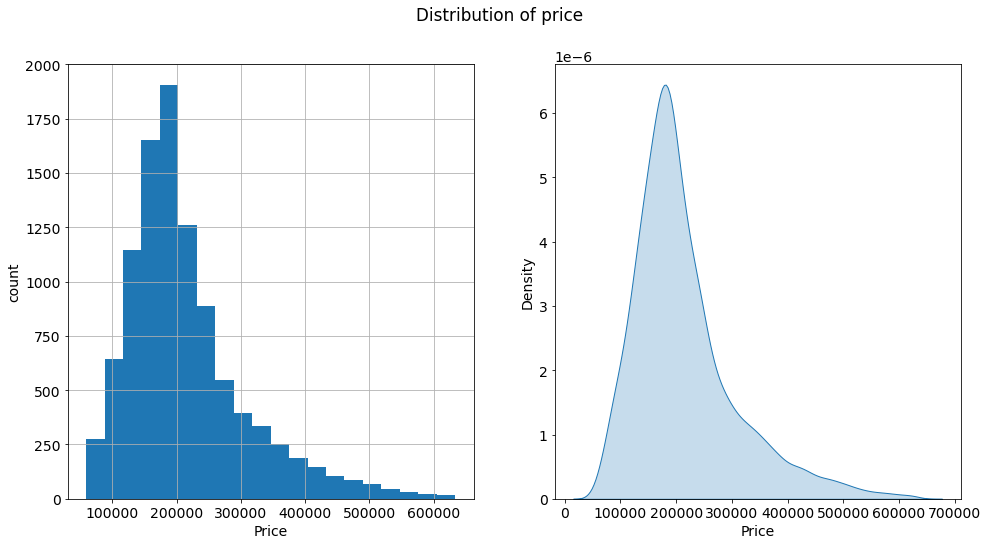

In [17]:
plt.figure(figsize = (16, 8))
plt.subplot(121)
train_df['Price'].hist(density = False, bins = 20)
plt.ylabel('count')
plt.xlabel('Price')

plt.subplot(122)
sns.kdeplot(train_df['Price'], shade = True, legend = False)
plt.xlabel('Price')
plt.suptitle('Distribution of price')
plt.show()

In [18]:
target_mean = round(train_df['Price'].mean(), 2)
target_median = train_df['Price'].median()
target_mode = train_df['Price'].mode()[0]
print(f'mean = {target_mean}, median = {target_median}, mode = {target_mode}')

mean = 214138.94, median = 192269.65625, mode = 182938.078125


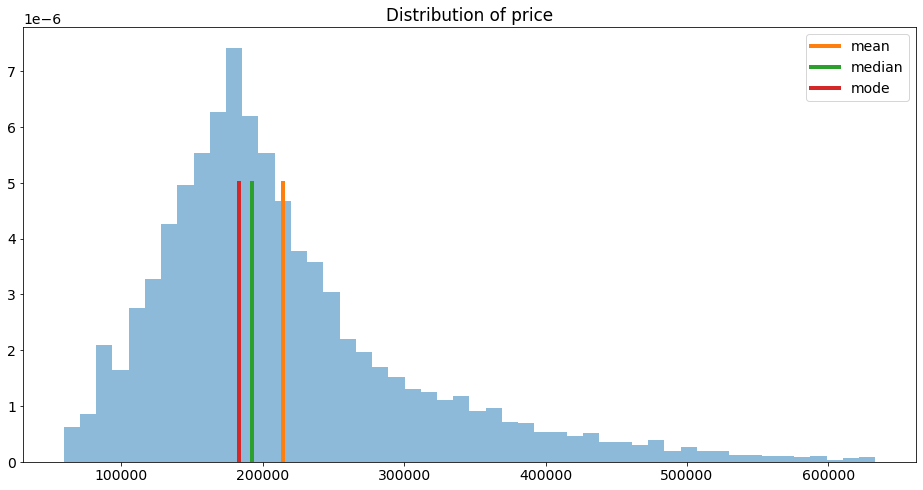

In [19]:
plt.figure(figsize = (16, 8))
plt.hist(train_df['Price'], density = True, bins = 50, alpha = 0.5)
y = np.linspace(0, 0.000005, 10)
plt.plot([target_mean] * 10, y, label = 'mean', linewidth = 4)
plt.plot([target_median] * 10, y, label = 'median', linewidth = 4)
plt.plot([target_mode] * 10, y, label = 'mode', linewidth = 4)
plt.title('Distribution of price')
plt.legend()
plt.show()

In [20]:
train_df_str = train_df.select_dtypes(exclude = 'number')
train_df_num = train_df.drop(train_df_str, axis = 1)
train_df_num

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
0,27,3.0,115.000000,NaN,10.0,4,10.0,2014,0.075439,11,3097,0,NaN,0,0,305018.875000
1,22,1.0,39.843750,23.171875,8.0,7,8.0,1966,0.118530,30,6207,1,1183.0,1,0,177734.546875
2,1,3.0,78.312500,47.687500,10.0,2,17.0,1988,0.025604,33,5261,0,240.0,3,1,282078.718750
3,1,1.0,40.406250,NaN,1.0,10,22.0,1977,0.007122,1,264,0,NaN,0,1,168106.000000
4,94,2.0,64.312500,38.562500,9.0,16,16.0,1972,0.282715,33,8667,2,NaN,0,6,343995.093750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,61,2.0,49.093750,33.281250,6.0,3,12.0,1981,0.300293,52,10311,6,NaN,1,9,119367.453125
9996,27,2.0,64.312500,37.031250,9.0,13,0.0,1977,0.072144,2,629,1,NaN,0,0,199715.156250
9997,178,1.0,29.640625,16.562500,5.0,3,5.0,1958,0.460449,20,4386,14,NaN,1,5,165953.906250
9998,21,1.0,32.343750,22.328125,5.0,3,9.0,1969,0.194458,47,8004,3,125.0,3,5,171842.406250


array([[<AxesSubplot:title={'center':'DistrictId'}>,
        <AxesSubplot:title={'center':'Rooms'}>,
        <AxesSubplot:title={'center':'Square'}>,
        <AxesSubplot:title={'center':'LifeSquare'}>],
       [<AxesSubplot:title={'center':'KitchenSquare'}>,
        <AxesSubplot:title={'center':'Floor'}>,
        <AxesSubplot:title={'center':'HouseFloor'}>,
        <AxesSubplot:title={'center':'HouseYear'}>],
       [<AxesSubplot:title={'center':'Ecology_1'}>,
        <AxesSubplot:title={'center':'Social_1'}>,
        <AxesSubplot:title={'center':'Social_2'}>,
        <AxesSubplot:title={'center':'Social_3'}>],
       [<AxesSubplot:title={'center':'Healthcare_1'}>,
        <AxesSubplot:title={'center':'Helthcare_2'}>,
        <AxesSubplot:title={'center':'Shops_1'}>,
        <AxesSubplot:title={'center':'Price'}>]], dtype=object)

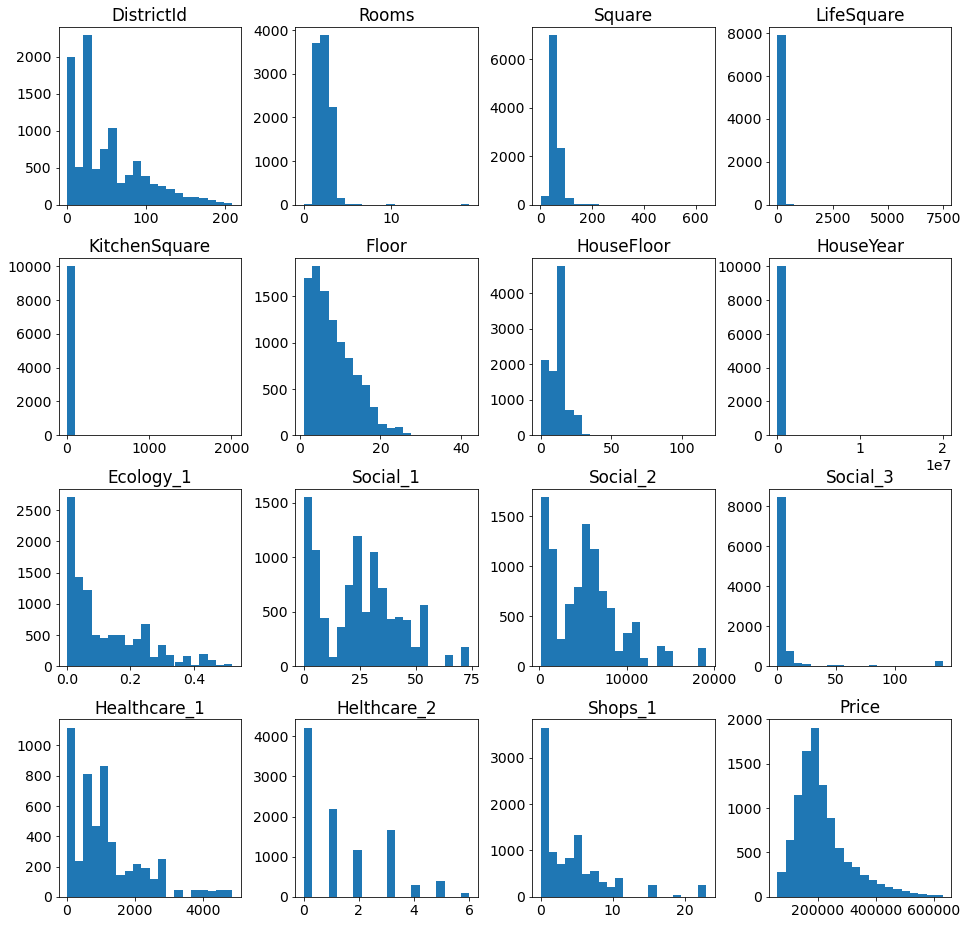

In [21]:
train_df_num.hist(figsize = (16, 16), bins = 20, grid = False)

In [22]:
train_df['HouseYear'].sort_values(ascending=False)

9163    20052011
8828        4968
7721        2020
9122        2020
7955        2020
          ...   
7610        1916
6250        1914
2066        1912
2795        1912
6794        1910
Name: HouseYear, Length: 10000, dtype: int32

In [23]:
class DataPreprocessing:
    """Подготовка исходных данных"""

    def __init__(self):
        """Параметры класса"""
        self.medians = None
        self.Ecology_1_quantile = None
        self.Healthcare_1_median = None
        
    def fit(self, X):
        """Сохранение статистик"""       
        # Расчет медиан
        self.medians = X.median()
        self.Ecology_1_quantile = X['Ecology_1'].quantile(0.25)
        self.Healthcare_1_median = X['Healthcare_1'].median()
    
    def transform(self, X):
        """Трансформация данных"""

        # Rooms
        X.loc[(X['Rooms'] == 0) | (X['Rooms'] >= 6), 'Rooms'] = self.medians['Rooms']
        
        # KitchenSquare
        X.loc[(X['KitchenSquare'] < 6) | (X['KitchenSquare'] > 100), 'KitchenSquare'] = self.medians['KitchenSquare']
                
        # HouseFloor
        X.loc[X['HouseFloor'] < 1, 'HouseFloor'] = self.medians['HouseFloor']
               
        # HouseYear
        X.loc[X['HouseYear'] > 2020, 'HouseYear'] = self.medians['HouseYear']
        
        # Social_1_2_3
        X.loc[(X['Social_1'] < 6) | (X['Social_1'] > 60), 'Social_1'] = self.medians['Social_1']
        X.loc[(X['Social_2'] < 1000) | (X['Social_2'] > 13000), 'Social_2'] = self.medians['Social_2']
        X.loc[(X['Social_3'] < 2) | (X['Social_3'] > 12), 'Social_3'] = self.medians['Social_3']
        
        # Healthcare
        X['Healthcare_1_nan'] = 0
        X.loc[X['Healthcare_1'].isna(), 'Healthcare_1_nan'] = 1
        X[X['Healthcare_1_nan'] == 1]
        X['Healthcare_1'].fillna(self.Healthcare_1_median, inplace=True)
        
        X.loc[(X['Healthcare_1'] < 500) | (X['Healthcare_1'] > 1600), 'Healthcare_1'] = self.medians['Healthcare_1']
        
        # Shops
        X.loc[(X['Shops_1'] < 1) | (X['Shops_1'] > 12), 'Shops_1'] = self.medians['Shops_1']
        
        # Ecology
        X.loc[(X['Ecology_1'] < self.Ecology_1_quantile), 'Ecology_1'] = self.Ecology_1_quantile
        
        # LifeSquare
        X['LifeSquare_nan'] = X['LifeSquare'].isna() * 1
        condition = (X['LifeSquare'].isna()) & \
                      (~X['Square'].isna()) & \
                      (~X['KitchenSquare'].isna())
        
        X.loc[condition, 'LifeSquare'] = X.loc[condition, 'Square'] - X.loc[condition, 'KitchenSquare'] - 3
        
        
        X.fillna(self.medians, inplace=True)
        
        return X

## Новые фичи

**Просмотр корреляции**

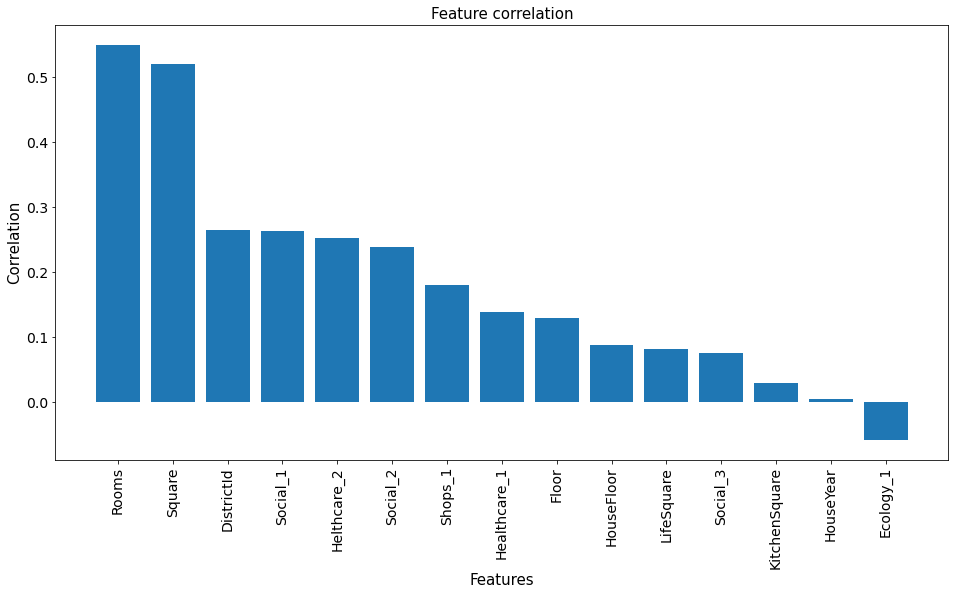

In [24]:
correlation = train_df.corrwith(train_df['Price']).sort_values(ascending=False)
correlation.drop('Price', inplace=True)

plt.figure(figsize = (16, 8))
plt.bar(correlation.index, correlation)
plt.xticks(rotation='90')
plt.xlabel('Features', fontsize=15)
plt.ylabel('Correlation', fontsize=15)
plt.title('Feature correlation', fontsize=15)
plt.show()

In [25]:
class FeatureGenerator():
    """Генерация новых фич"""
    
    def __init__(self):
        self.binary_features = None
        self.district_size = None
        self.medprice_DistRooms = None
        self.medprice_fl_yr_byDist = None
        
    def fit(self, X, y=None):
        
        X = X.copy()
        
        # Binary features
        self.binary_features = {'A': 0, 'B': 1}
        
        # District
        self.district_size = X['DistrictId'].value_counts().reset_index() \
                               .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
        self.district_size_median = self.district_size['DistrictSize'].median()
     
        # Target encoding
        ## District, Rooms
        df = X.copy()
        
        if y is not None:
            df['Price'] = y.values
            self.medprice_DistRooms = df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                                            .rename(columns={'Price':'medprice_DistRooms'})
            self.medprice_DistRooms_median = self.medprice_DistRooms['medprice_DistRooms'].median()
            
        ## floor, year
        if y is not None:
            df['Price'] = y.values
            df = self.floor_to_cat(df)
            df = self.year_to_cat(df)
            df = self.housefloor_to_cat(df)
            self.medprice_fl_yr_byDist = df.groupby(['DistrictId', 'year_cat', 'floor_cat', 'housefloor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'medprice_fl_yr_byDist'})
            self.medprice_fl_yr_byDist_median = self.medprice_fl_yr_byDist['medprice_fl_yr_byDist'].median()
            
        
    def transform(self, X):
        
        # Binary features
        X['Ecology_2'] = X['Ecology_2'].map(self.binary_features)
        X['Ecology_3'] = X['Ecology_3'].map(self.binary_features)
        X['Shops_2'] = X['Shops_2'].map(self.binary_features)
        
        X['Ecology_2'] = X['Ecology_2'].astype(int)
        X['Ecology_3'] = X['Ecology_3'].astype(int)
        X['Shops_2'] = X['Shops_2'].astype(int)
        
        # District
        X = X.merge(self.district_size, on='DistrictId', how='left')
        
        X['new_district'] = 0
        X.loc[X['DistrictSize'].isna(), 'new_district'] = 1
        X['DistrictSize'].fillna(self.district_size_median, inplace=True)
                
        # More categorical features
        X = self.floor_to_cat(X)
        X = self.year_to_cat(X)  
        X = self.housefloor_to_cat(X)
        
        # Target encoding
        if self.medprice_DistRooms is not None:
            X = X.merge(self.medprice_DistRooms, on=['DistrictId', 'Rooms'], how='left')
            X['medprice_DistRooms'].fillna(self.medprice_DistRooms_median, inplace=True)
            
        if self.medprice_fl_yr_byDist is not None:
            X = X.merge(self.medprice_fl_yr_byDist, on=['DistrictId', 'year_cat', 'floor_cat', 'housefloor_cat'], how='left')
            X['medprice_fl_yr_byDist'].fillna(self.medprice_fl_yr_byDist_median, inplace=True)

        
        return X
    
    def year_to_cat(self, X):

        X['year_cat'] = 0

        X.loc[X['HouseYear'] <= 1950, 'year_cat'] = 1
        X.loc[(X['HouseYear'] > 1950) & (X['HouseYear'] <= 1970), 'year_cat'] = 2
        X.loc[(X['HouseYear'] > 1971) & (X['HouseYear'] <= 1990), 'year_cat'] = 3
        X.loc[(X['HouseYear'] > 1991) & (X['HouseYear'] <= 2020), 'year_cat'] = 4

        return X

    def floor_to_cat(self, X):

        X['floor_cat'] = 0

        X.loc[X['Floor'] <= 3, 'floor_cat'] = 1
        X.loc[(X['Floor'] > 3) & (X['Floor'] <= 8), 'floor_cat'] = 2
        X.loc[X['Floor'] > 8, 'floor_cat'] = 3

        return X

    def housefloor_to_cat(self, X):

        X['housefloor_cat'] = 0

        X.loc[X['HouseFloor'] <= 3, 'housefloor_cat'] = 1
        X.loc[(X['HouseFloor'] > 3) & (X['HouseFloor'] <= 5), 'housefloor_cat'] = 2
        X.loc[(X['HouseFloor'] > 5) & (X['HouseFloor'] <= 9), 'housefloor_cat'] = 3
        X.loc[X['HouseFloor'] > 9, 'housefloor_cat'] = 4

        return X

## Отбор признаков

In [26]:
train_df.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price']

In [27]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3',
                 'Helthcare_2', 'Shops_1', 'Shops_2']

new_feature_names = ['medprice_DistRooms', 'medprice_fl_yr_byDist', 'DistrictSize', 'LifeSquare_nan', 'Healthcare_1_nan']

target_name = 'Price'

## Разбиение на train и valid

In [28]:
X = train_df.drop(columns=target_name)
y = train_df[target_name]

In [29]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=21)

In [30]:
preprocessor = DataPreprocessing()
preprocessor.fit(X_train)

X_train = preprocessor.transform(X_train)
X_valid = preprocessor.transform(X_valid)
test_df = preprocessor.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((8000, 21), (2000, 21), (5000, 21))

In [31]:
features_gen = FeatureGenerator()
features_gen.fit(X_train, y_train)

X_train = features_gen.transform(X_train)
X_valid = features_gen.transform(X_valid)
test_df = features_gen.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((8000, 28), (2000, 28), (5000, 28))

In [32]:
X_train = X_train[feature_names + new_feature_names]
X_valid = X_valid[feature_names + new_feature_names]
test_df = test_df[feature_names + new_feature_names]

In [33]:
X_train.isna().sum().sum(), X_valid.isna().sum().sum(), test_df.isna().sum().sum()

(0, 0, 0)

## Моделирование

In [34]:
# gb_model = GradientBoostingRegressor(criterion='mse', max_depth=5, min_samples_leaf=4, random_state=21, n_estimators=200)
# gb_model.fit(X_train, y_train)
# y_train_preds = gb_model.predict(X_train)
# y_test_preds = gb_model.predict(X_valid)

# evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

Train R2:	0.98
Test R2:	0.704


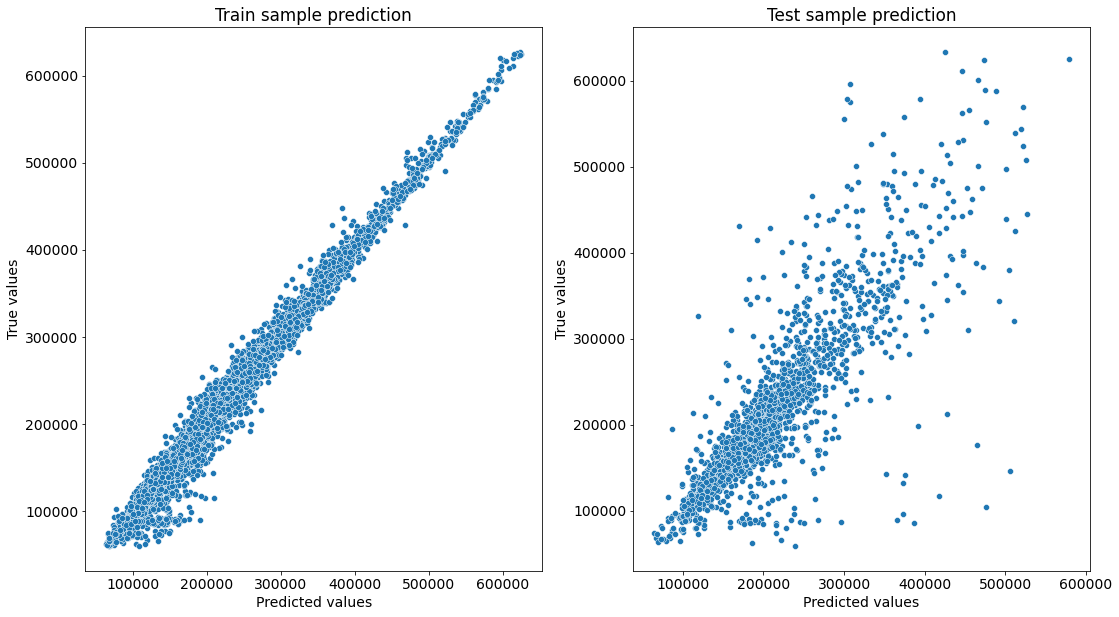

In [35]:
final_model = CatBoostRegressor(
    silent=True,
    learning_rate=0.1,
    iterations=1150,
    eval_metric='R2',
    depth=8
)

final_model.fit(X_train, y_train)
y_train_preds = final_model.predict(X_train)
y_test_preds = final_model.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

**Важность признаков**

In [36]:
feature_importances = pd.DataFrame(zip(X_train.columns, final_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
17,medprice_fl_yr_byDist,23.217576
1,Square,18.967071
16,medprice_DistRooms,12.056932
6,HouseYear,6.700192
18,DistrictSize,5.260638
2,LifeSquare,4.773501
4,Floor,4.173885
3,KitchenSquare,3.835761
5,HouseFloor,3.448652
7,Ecology_1,3.278174


**Прогнозирование на тестовом датасете**

In [37]:
test_df.shape

(5000, 21)

In [38]:
test_df

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,...,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,medprice_DistRooms,medprice_fl_yr_byDist,DistrictSize,LifeSquare_nan,Healthcare_1_nan
0,1.0,36.847630,19.094182,6.0,5,9.0,1970,0.036122,1,1,...,4378,2,1,1,1,170455.937500,170455.937500,86.0,0,0
1,1.0,42.493907,42.568133,10.0,7,17.0,2017,0.072158,1,1,...,5285,2,0,3,0,130720.195312,159077.203125,193.0,0,1
2,2.0,59.463678,47.463678,9.0,19,19.0,1977,0.211401,1,1,...,1892,2,0,1,1,166353.734375,143627.531250,691.0,1,1
3,3.0,49.646030,33.893825,6.0,2,2.0,1965,0.017654,1,1,...,5285,2,0,3,1,173257.953125,212668.343750,444.0,0,1
4,1.0,53.837056,44.837056,6.0,8,17.0,1977,0.309479,1,1,...,7715,4,0,6,1,164116.187500,227600.375000,81.0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,2.0,43.177521,30.339945,6.0,6,5.0,1962,0.069660,1,1,...,6119,4,1,2,1,185083.531250,170158.203125,69.0,0,1
4996,3.0,93.698122,94.521465,10.0,21,27.0,2018,0.060753,1,1,...,2787,2,0,7,1,425037.656250,329248.593750,29.0,0,0
4997,1.0,33.656723,19.003259,6.0,2,5.0,1966,0.038693,1,1,...,6533,2,2,5,1,153273.640625,188383.312500,70.0,0,0
4998,1.0,38.635155,20.976257,9.0,8,14.0,1970,0.089040,1,1,...,7976,5,0,11,1,169259.765625,212668.343750,46.0,0,1


In [39]:
submit = pd.read_csv('C:/Users/grind/project_data_from_kaggle/sample_submission.csv')
submit.head()

,Id,Price
0,4567,200000.0
1,5925,200000.0
2,960,200000.0
3,3848,200000.0
4,746,200000.0


In [40]:
predictions = final_model.predict(test_df)
predictions

array([157959.71459381, 116042.92072604, 142035.90083451, ...,
       154096.02259335, 198305.354761  , 278625.23797028])

In [41]:
submit['Price'] = predictions
submit.head()

,Id,Price
0,4567,157959.714594
1,5925,116042.920726
2,960,142035.900835
3,3848,182435.675368
4,746,199362.996918


In [42]:
submit.to_csv('cb_submit.csv', index=False)